# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [2]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [3]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [4]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta['ABBREVIATION'] = kta['ABBREVIATION'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
atk['KEGG ID(S)'] = atk['KEGG ID(S)'].str.lower() # set to lower case for better matching
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk = atk.groupby('ABBREVIATION').first() # take the first KEGG ID in each group

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [5]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [30]:
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD9.xlsx', sheet_name = 'reactions')
allRxnDf

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,ATPase1,ATP + H2O <=> ADP + Pi,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
5,PGMT,Glucose-1-phosphate <=> D-glucose-6-phosphate,g1p <=> g6p,C00103 <=> C00092,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,PGI,D-Glucose-6-phosphate <=> D-Fructose-6-phosphate,g6p <=> f6p,C00092 <=> C00085,NaN,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,PFK-PPi,PPi + D-fructose-6-phosphate <=> Phosphate + D...,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,NaN,2,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
8,PFK-ATP,ATP + D-Fructose-6-phosphate <=> ADP + D-Fruct...,atp + f6p <=> adp + fdp,C00002 + C00085 <=> C00008 + C00354,NaN,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,FBA,"D-Fructose-1,6-bisphosphate <=> Glycerone-phos...",fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,NaN,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [31]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
fluxSet = 'ppi-pfk'
for f in range(len(fluxSet)):
    selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
    selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
    #rxnlist[f]= selectedRxnDf  

In [32]:
#Import metabolite data from excel file
Met_bound = pd.read_excel('cth_thermo_model_DO_SD9.xlsx', sheet_name = 'metabolite_bounds')
Alldata = pd.read_excel('./metabolite_data/lt_dataset2_quantified.xlsx')
Met_data = Alldata.loc[Alldata['Replicate'] != 0, ['Timepoint', 'KEGG_ID', 'compound','amount_int', 'Sample','Replicate','Maven filename']]
Met_data[:2]

,Timepoint,KEGG_ID,compound,amount_int,Sample,Replicate,Maven filename
0,2,C00197,3PG,217.958918,A,1,A1_1
1,2,C00197,3PG,137.397616,A,2,A1_2


In [33]:
Met_data_WT = pd.read_excel('cth_thermo_model_DO_SD9.xlsx', sheet_name = 'WT_data')
Met_data_WT

,Name,KEGG_ID,Abbreviation,Concentration
0,Glucose-6-phosphate,C00092,g6p,0.008192
1,Fructose-6-phosphate,C00085,f6p,0.001494
2,Glucose-1-phosphate,C00103,g1p,0.006663
3,Fructose 1_6-bisphosphate,C00354,fdp,0.001497
4,Malate,C00149,mal-l,0.037807
5,DHAP,C00111,dhap,0.001270
6,GAP,C00118,g3p,0.000102
7,3-phosphoglycerate,C00197,3pg,0.001348
8,Phosphoenolpyruvate,C00074,pep,0.000690
9,pyruvate,C00022,pyr,0.012655


In [34]:
# parse the KeggFormula column to create eQuilibrator Reaction objects
# create reaction list
reactions = []
for i, row in selectedRxnDf.iterrows():
    rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
    if (rxn.check_full_reaction_balancing()):
        reactions.append(rxn)
    else:
        print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
# create flux list
fluxes = selectedRxnDf['flux'].values

# need to declare pH and ionic strength constants at the beginning
PH = 7.0
IS = 0.1

# calculate dGO_r_primes
dG0_r_primes = []
for r in reactions:
    result = r.dG0_prime(pH = PH, ionic_strength = IS)
    #print(result)
    dG0_r_primes.append(result)

In [35]:
# set up the model
pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)

In [36]:
# Check MDF using Daniel's data
all_data={}
Uf = 1.5 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
   
for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
    pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'])
for i, dat in Met_data_WT.iterrows():
    if dat['KEGG_ID'] not in ['C00002','C00008','C00035','C00044','C00022','C00103']:
        pp.bounds.SetBounds(dat['KEGG_ID'],dat['Concentration']*.50,dat['Concentration']*1.5) 
    else:
        pp.bounds.SetBounds(dat['KEGG_ID'],1e-6,1e-2) 
pp.bounds.SetBounds('C00469',1e-6,1e-2)     
mdf_data,con = pp.conc_mdf()
print(mdf_data.mdf)
k=0
atp_ratio=1
gtp_ratio=1
nadh_ratio=1
for r in mdf_data.reaction_data:
    print (r.reaction.reaction_id,r.dGr,r.shadow_price)
for c in mdf_data.compound_data:
    print(ktaDict[c.compound], c.concentration,con[k],mdf_data.model.concentration_bounds.GetBoundTuple(c.compound),c.shadow_price)
    k= k+1
    if c.compound in ['C00002']:
        atp_ratio=atp_ratio*c.concentration
    elif c.compound in ['C00008']:
        atp_ratio=atp_ratio/c.concentration
    elif c.compound in ['C00003']:
        nadh_ratio=nadh_ratio/c.concentration
    elif c.compound in ['C00004']:
        nadh_ratio=nadh_ratio*c.concentration
    elif c.compound in ['C00035']:
        gtp_ratio=gtp_ratio/c.concentration
    elif c.compound in ['C00044']:
        gtp_ratio=gtp_ratio*c.concentration
print('atp_ratio =',atp_ratio)
print('gtp_ratio =',gtp_ratio)
print('nadh_ratio =',nadh_ratio)        

2.122886861024691
ATPase1 -33.99453398129833 0.0
CBP -2.1228868610246874 0.0
GLK-GTP -9.312337516350503 -3.734161924141044e-18
PGMT -6.910242629069399 0.0
PGI -2.12288686102469 -1.792397723587727e-16
PFK-PPi -5.63171987244192 8.401864329317477e-17
FBA -3.7192824416617505 8.401864329317477e-17
TPI -2.1228868610246936 8.401864329317477e-17
GAPDH -2.1228868610246874 5.433129131850481e-17
PGK-GTP -2.122886861024707 8.58857242552453e-17
PGM -2.1228868610246883 0.500000000000001
ENO -2.1228868610246954 0.5000000000000007
PPDK -8.334248621750355 0.0
PFOR -2.122886861024675 0.0
RNF_PPiase -35.43023666833566 0.0
ALDH-NADH -2.122886861024707 5.041118597590493e-17
ADH-NADH -3.3453262325843554 3.920105342599885e-18
NDK -2.12288686102469 1.935237063963606e-16
ATPase2 -48.80713779992142 0.0
PTA -2.1228868610246856 0.0
ACK -15.017526037677356 -1.935237063963606e-16
h2o 1.0 (1.0, 1.0) (1.0, 1.0) -1.2388132500000013
atp 0.0021502180183049667 (9.999999999999987e-07, 0.0021502180183049836) (1e-06, 0.01) 

In [37]:
all_data={}
Uf = 1.5 #Uncertainity factor 
 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
cnt=0
for sm in range(12): # divide the samples into datasets
    all_data[sm]={}
    ditcur={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
    ref_conc = {}
    for i, dat in Met_data.iterrows():
        if (dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep):
            ref_conc.update({dat['KEGG_ID']: dat['amount_int']/1e6 })
            if dat['KEGG_ID'] not in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006","C00111","C00354","C00197"]: 
                lb = dat['amount_int']/(2 *1e6)
                ub = dat['amount_int']/1e6 *Uf
                if lb < DEFAULT_LB:    
                    lb = DEFAULT_LB

                if lb > DEFAULT_UB:
                    lb = DEFAULT_UB

                        
   
                if ub < DEFAULT_LB:
                    ub = DEFAULT_LB

                if ub > DEFAULT_UB:
                    ub = DEFAULT_UB
                
                pp.bounds.SetBounds(dat['KEGG_ID'], lb, ub)
            #if dat['KEGG_ID'] in ["C00024"]:
                #pp.bounds.SetBounds(dat['KEGG_ID'], dat['amount']/(1e6 * 3), dat['amount']/1e6 * 3)
            if tym  == 2 and smple == 'A':
                pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
            elif tym ==5 and smple == 'A':
                pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
            elif tym ==9 and smple == 'A':
                pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
            if tym  == 2 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
            elif tym ==5 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
            elif tym ==9 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
    mdf_data, con = pp.conc_mdf()
    print(sm,smple,tym,rep,mdf_data.mdf)
    ditcur['mdf']=mdf_data
    ditcur['conc']=con
    ditcur['c_bounds']={str(c.compound): (mdf_data.model.concentration_bounds.GetBoundTuple(str(c.compound))) for c in mdf_data.compound_data}
    all_data[sm]=ditcur
    atp_ratio=1
    gtp_ratio=1
    nadh_ratio=1
    for c in mdf_data.compound_data:
        if c.compound in ['C00002']:
            atp_ratio=atp_ratio*c.concentration
        elif c.compound in ['C00008']:
            atp_ratio=atp_ratio/c.concentration
        elif c.compound in ['C00003']:
            nadh_ratio=nadh_ratio/c.concentration
        elif c.compound in ['C00004']:
            nadh_ratio=nadh_ratio*c.concentration
        elif c.compound in ['C00035']:
            gtp_ratio=gtp_ratio/c.concentration
        elif c.compound in ['C00044']:
            gtp_ratio=gtp_ratio*c.concentration
        #print(c.compound, log(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)), sm,log(all_data[0]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound)))
    print('atp_ratio =',atp_ratio)
    print('gtp_ratio =',gtp_ratio)
    print('nadh_ratio =',nadh_ratio)  

0 A 2 1 1.5970277910924295
atp_ratio = 9.999999999999993
gtp_ratio = 51.6401353077562
nadh_ratio = 0.0505521875257732
1 A 5 1 0.1462117093412587
atp_ratio = 9.999999999999993
gtp_ratio = 28.75271739965476
nadh_ratio = 0.32903197174532145
2 A 9 1 -0.10311825756122772
atp_ratio = 12.145990277578278
gtp_ratio = 31.579674354147258
nadh_ratio = 0.4049418105363158
3 A 2 2 1.274829344536446
atp_ratio = 9.999999999999977
gtp_ratio = 45.34300858956601
nadh_ratio = 0.07317719670428605
4 A 5 2 1.3715521439759186
atp_ratio = 9.999999999999993
gtp_ratio = 47.148136708059006
nadh_ratio = 0.01104423945787961
5 A 9 2 -0.10740472187598726
atp_ratio = 13.312053768513284
gtp_ratio = 34.55162057609743
nadh_ratio = 0.4063453918155398
6 B 2 1 1.4979017275368776
atp_ratio = 9.99999999999995
gtp_ratio = 49.61487603866974
nadh_ratio = 0.03650847639700135
7 B 5 1 1.4819391159892508
atp_ratio = 9.999999999999993
gtp_ratio = 49.29624964046657
nadh_ratio = 0.05389185451693355
8 B 9 1 1.5979415684324678
atp_ratio =

ATPase1 0.0
CBP 0.0
GLK-GTP 0.0
PGMT 0.0
PGI 0.0625
PFK-PPi 0.062499999999999986
FBA 0.06249999999999996
TPI 0.06249999999999996
GAPDH 0.12499999999999989
PGK-GTP 0.12499999999999993
PGM 0.12499999999999993
ENO 0.12499999999999992
PPDK 0.0
PFOR 0.0
RNF_PPiase 0.0
ALDH-NADH 0.062499999999999944
ADH-NADH 0.062499999999999944
NDK 0.12499999999999993
ATPase2 0.0
PTA 0.0
ACK 0.0
1.5970277910924295
h2o 1.0 (1.0, 1.000000000000004) 1.0 1.0 -0.3097033124999997
atp 0.0010000000000000002 (0.0009999999999999994, 0.0010000000000000037) 0.001 0.02 -0.30970331249999977
nadh 5.055218752577325e-06 (5.05521875257736e-06, 5.05521875257737e-06) 1e-06 0.01 0.0
adp 0.00010000000000000009 (9.999999999999956e-05, 0.00010000000000000009) 0.0001 0.0001 0.30970331249999977
pi 0.009999999999999978 (0.010000000000000014, 0.010000000000000014) 0.01 0.01 0.15485165624999972
coa 2.6117887838238195e-05 (2.6117887838238195e-05, 2.6117887838238472e-05) 2.611788783823813e-05 7.835366351471439e-05 -0.15485165624999983
pp

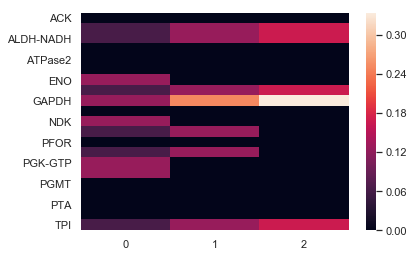

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fng_data={}
for t in range(3):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.shadow_price)
    k=0
    print(all_data[t]['mdf'].mdf)
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if c.shadow_price!=0:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        elif ktaDict[c.compound] in ["nadh","g3p","dhap"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        k=k+1
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

ATPase1 0.0
CBP 0.0
GLK-GTP 0.0
PGMT 0.0
PGI 0.12500000000000028
PFK-PPi 0.12500000000000033
FBA 0.1250000000000002
TPI 0.1250000000000002
GAPDH 0.2500000000000005
PGK-GTP -2.688596585381586e-17
PGM -1.792397723587727e-16
ENO 0.0
PPDK 0.0
PFOR 0.0
RNF_PPiase 0.0
ALDH-NADH 0.12500000000000033
ADH-NADH 0.12500000000000017
NDK -2.688596585381586e-17
ATPase2 0.0
PTA 0.0
ACK 0.0
h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
nadh 7.317719670428624e-06 (7.317719670428663e-06, 7.317719670428598e-06) 1e-06 0.01
adp 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
pi 0.009999999999999995 (0.009999999999999995, 0.009999999999999995) 0.01 0.01
co2 9.999999999999874e-06 (9.999999999999997e-06, 9.999999999999997e-06) 1e-05 1e-05
amp 0.00010000000000000009 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
gdp 0.00010000000000000009 (0.00010000000000000009, 0.00010000000000000009) 0

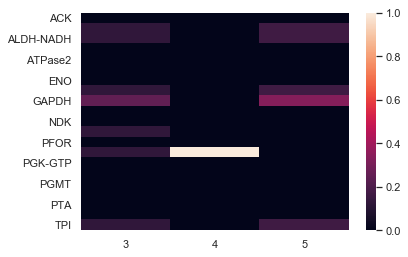

In [39]:
fng_data={}
for t in range(3,6):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.shadow_price)
    k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if (all_data[t]['conc'][k][0]==all_data[t]['conc'][k][1]):
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        elif ktaDict[c.compound] in ["nadh","g6p","f6p","g3p","dhap"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)
print(fng_data[5])

ATPase1 0.0
CBP 0.0
GLK-GTP 0.0
PGMT 0.0
PGI 0.9999999999999977
PFK-PPi -1.039556606872063e-18
FBA 0.0
TPI 0.0
GAPDH -1.039556606872063e-18
PGK-GTP -1.8276895943837606e-17
PGM 2.079113213744126e-18
ENO 0.0
PPDK 0.0
PFOR 0.0
RNF_PPiase 0.0
ALDH-NADH 0.0
ADH-NADH -1.039556606872063e-18
NDK -1.8276895943837606e-17
ATPase2 0.0
PTA 0.0
ACK 0.0
h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 9.999999999999973e-05 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
nadh 3.650847639700125e-06 (3.650847639700151e-06, 6.084153902160007e-06) 1e-06 0.01
adp 0.00010000000000000009 (9.999999999999991e-05, 9.999999999999991e-05) 0.0001 0.0001
pi 0.010000000000000014 (0.010000000000000004, 0.010000000000000004) 0.01 0.01
co2 9.999999999999997e-06 (9.999999999999997e-06, 9.999999999999997e-06) 1e-05 1e-05
gdp 9.999999999999956e-05 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
f6p 0.0009461946438219866 (0.0009461946438219875, 0.0009461946438219841) 0.0009461946438219875 0.0028385839314659625


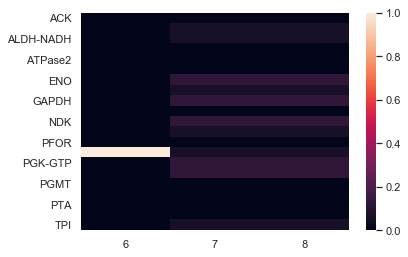

In [40]:
fng_data={}
for t in range(6,9):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.shadow_price)
    k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if (all_data[t]['conc'][k][0]==all_data[t]['conc'][k][1]):
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        elif ktaDict[c.compound] in ["nadh","g6p","f6p"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 9.999999999999991e-05 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
nadh 2.640136905461801e-06 (2.6401369054618056e-06, 8.716223153540413e-06) 1e-06 0.01
adp 0.00010000000000000026 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
pi 0.009999999999999978 (0.009999999999999986, 0.009999999999999986) 0.01 0.01
co2 9.999999999999997e-06 (9.999999999999997e-06, 9.999999999999997e-06) 1e-05 1e-05
amp 0.00010000000000000009 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
gdp 0.00010000000000000026 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
fdxox 0.00010000000000000009 (9.999999999999991e-05, 9.999999999999991e-05) 0.0001 0.0001
etoh 0.0043478260869565365 (0.004347826086956517, 0.004347826086956517) 0.004347826086956522 0.004347826086956522
h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 0.00010000000000000026 (9.999999999999991e-05, 9.999999999999991e-05) 0.0001 0.0001
nadh 8.195618996632289e-06 (8.195618996632289

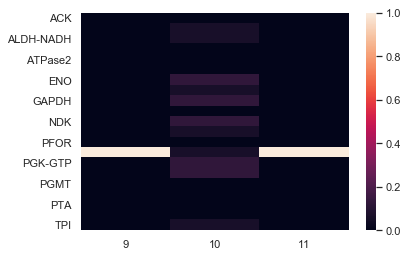

In [41]:
fng_data={}
for t in range(9,12):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if (all_data[t]['conc'][k][0]==all_data[t]['conc'][k][1]):
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        elif ktaDict[c.compound] in ["nadh"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)